<a href="https://colab.research.google.com/github/neverm1nddd/repos/blob/main/%D0%9A%D0%BE%D0%BF%D0%B8%D1%8F_%D0%B1%D0%BB%D0%BE%D0%BA%D0%BD%D0%BE%D1%82%D0%B0_%222_Classification_with_Multilayer_Perceptron_%5BTensorflow%5D_ipynb%22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **В данном блокноте демонстрируется общий принцип построения архитектуры многослойного персептрона для задачи классификации.**



# **Пример задачи бинарной классификации**

Используемый набор данных "titanic_prepared.csv" представляет собой уже очищенную и подготвленную версию [оригинального набора данных](https://www.kaggle.com/competitions/titanic/data) для быстрого и лёгкого обучения моделей машинного и глубокого обучения. Также была проведена инженерия признаков для добавления новых информативных характеристик пассажиров.

**В этой задаче классификации цель — предсказать, выжил ли пассажир на «Титанике» или нет, основываясь данных пассажиров.**

Описание характеристик (признаков) пассажира:
0. **Выжил (целевая переменная)**: Указывает, выжил пассажир или нет (0 — не выжил, 1 — выжил).
1. **Титул**: Титул, который использовался при обращении к пассажиру (Mr., Mrs., Miss., Master и т.д.).
2. **Длина имени**: Длина имени пассажира, включая все символы.
3. **Пол**: Пол пассажира (male — мужчина, female — женщина).
4. **Возраст**: Возраст пассажира в годах. Значение может быть пустым, если возраст неизвестен.
5. **Братья сёстры супруги**: Количество братьев, сестер и супругов, находящихся с пассажиром на борту.
6. **Родители и дети**: Количество родителей и детей, находящихся с пассажиром на борту.
7. **Один**: Бинарный признак, указывающий, путешествовал ли пассажир один (0 — с семьей, 1 — один).
8. **Маленькая семья**: Бинарный признак, указывающий, был ли пассажир с маленькой семьёй (0 — нет, 1 — да).
9. **Большая семья**: Бинарный признак, указывающий, был ли пассажир с большой семьёй (0 — нет, 1 — да).
10. **Класс билета**: Класс билета, который был у пассажира (1 — первый класс, 2 — второй, 3 — третий).
11. **Длина билета**: Длина номера билета, включая все символы.
12. **Стоимость билета**: Стоимость билета, уплаченная пассажиром.
13. **Каюта**: Номер каюты пассажира.
14. **Порт посадки**: Порт посадки пассажира на корабль (C — Шербур, Q — Квинстаун, S — Саутгемптон).

In [ ]:
import numpy as np
import tensorflow as tf
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras import Model, Input
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt

## **1. Подготовка набора данных для обучения многослойного персептрона**

In [ ]:
df = pd.read_csv('/content/titanic_prepared.csv', encoding='cp1251') # загрузка набора данных, используя библиотеку pandas
df # вывод набора данных

,Выжил,Титул,Длина имени,Пол,Возраст,Братья сёстры супруги,Родители и дети,Один,Маленькая семья,Большая семья,Класс билета,Длина билета,Стоимость билета,Каюта,Порт посадки
0,0,Mr.,23,male,22.0,1,0,0,1,0,3,9,7.2500,G,S
1,1,Mrs.,51,female,38.0,1,0,0,1,0,1,8,71.2833,Other,C
2,1,Miss.,22,female,26.0,0,0,1,0,0,3,16,7.9250,G,S
3,1,Mrs.,44,female,35.0,1,0,0,1,0,1,6,53.1000,Other,S
4,0,Mr.,24,male,35.0,0,0,1,0,0,3,6,8.0500,G,S
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1304,0,Mr.,18,male,32.0,0,0,1,0,0,3,9,8.0500,G,S
1305,1,Other,28,female,39.0,0,0,1,0,0,1,8,108.9000,Other,C
1306,0,Mr.,28,male,38.5,0,0,1,0,0,3,18,7.2500,G,S
1307,0,Mr.,19,male,32.0,0,0,1,0,0,3,6,8.0500,G,S


In [ ]:
# Выполняем простое числовое кодирование категорий "Титул", "Каюта" и "Порт посадки" с помощью Label Encoding
# Label Encoding заключается в присвоении уникального числового значения каждой категории (0, 1, 2 и так далее).
# Этот метод особенно подходит, когда у категорий существует естественный порядок, например, низкий, средний, высокий.
# Однако ничто не мешает его использовать и для категорий без порядка, но в особых случаях есть риск, что это может ввести модель в заблуждение, думая что в категориях есть некий приоритет.

# Инициализируем объект для Label Encoding и применяем его к строковым категориальным переменным.
label_encoder = LabelEncoder()
df['Титул'] = label_encoder.fit_transform(df['Титул'])
df['Каюта'] = label_encoder.fit_transform(df['Каюта'])
df['Порт посадки'] = label_encoder.fit_transform(df['Порт посадки'])

# Альтернативно попробуйте one-hot кодирование
# One-Hot Encoding — это метод преобразования категориальных переменных в бинарные (0 и 1) столбцы. Каждая категория представляется отдельным столбцом, где 1 обозначает присутствие категории, а 0 — её отсутствие.
# Не рекомендуется использовать в случаях, когда присутствует огромное количество категорий, поскольку это может привести к созданию большого числа новых признаков (столбцов), что может привести к проблемам из-за разреженности данных (много нулей) и увеличению размера данных.
# df = pd.get_dummies(df, columns=['Титул', 'Каюта', 'Порт посадки'], dtype=int)

# Преобразование признака Пол в бинарный вид: male -> 1, female -> 0
df['Пол'] = df['Пол'].map({'male': 0, 'female': 1})

In [ ]:
df

,Выжил,Титул,Длина имени,Пол,Возраст,Братья сёстры супруги,Родители и дети,Один,Маленькая семья,Большая семья,Класс билета,Длина билета,Стоимость билета,Каюта,Порт посадки
0,0,4,23,0,22.0,1,0,0,1,0,3,9,7.2500,14,2
1,1,5,51,1,38.0,1,0,0,1,0,1,8,71.2833,16,0
2,1,3,22,1,26.0,0,0,1,0,0,3,16,7.9250,14,2
3,1,5,44,1,35.0,1,0,0,1,0,1,6,53.1000,16,2
4,0,4,24,0,35.0,0,0,1,0,0,3,6,8.0500,14,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1304,0,4,18,0,32.0,0,0,1,0,0,3,9,8.0500,14,2
1305,1,6,28,1,39.0,0,0,1,0,0,1,8,108.9000,16,0
1306,0,4,28,0,38.5,0,0,1,0,0,3,18,7.2500,14,2
1307,0,4,19,0,32.0,0,0,1,0,0,3,6,8.0500,14,2


In [ ]:
# Определяем целевую переменную y и признаки X
y = df['Выжил']
X = df.drop(columns=['Выжил'])

In [ ]:
# Масштабирование данных (стандартизация или нормализация)
# Масштабирование данных применяется только количественным непрерывным переменным (например, Длина имени, Возраст, Длина билета, Стоимость билета)

# Используем нормализацию для приведения значений в диапазон от 0 до 1.
minmax_scaler = MinMaxScaler()
quantitative_cols = ['Длина имени', 'Возраст', 'Длина билета', 'Стоимость билета'] # Определение списка количественных переменных
X[quantitative_cols] = minmax_scaler.fit_transform(X[quantitative_cols])

# Альтернативно можно попробовать стандартизацию
# standard_scaler = StandardScaler()
# quantitative_cols = ['Длина имени', 'Возраст', 'Длина билета', 'Стоимость билета'] # Определение списка количественных переменных
# X[quantitative_cols] = standard_scaler.fit_transform(X[quantitative_cols])

In [ ]:
X

,Титул,Длина имени,Пол,Возраст,Братья сёстры супруги,Родители и дети,Один,Маленькая семья,Большая семья,Класс билета,Длина билета,Стоимость билета,Каюта,Порт посадки
0,4,0.157143,0,0.273456,1,0,0,1,0,3,0.400000,0.014151,14,2
1,5,0.557143,1,0.473882,1,0,0,1,0,1,0.333333,0.139136,16,0
2,3,0.142857,1,0.323563,0,0,1,0,0,3,0.866667,0.015469,14,2
3,5,0.457143,1,0.436302,1,0,0,1,0,1,0.200000,0.103644,16,2
4,4,0.171429,0,0.436302,0,0,1,0,0,3,0.200000,0.015713,14,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1304,4,0.085714,0,0.398722,0,0,1,0,0,3,0.400000,0.015713,14,2
1305,6,0.228571,1,0.486409,0,0,1,0,0,1,0.333333,0.212559,16,0
1306,4,0.228571,0,0.480145,0,0,1,0,0,3,1.000000,0.014151,14,2
1307,4,0.100000,0,0.398722,0,0,1,0,0,3,0.200000,0.015713,14,2


In [ ]:
# Переводим целевую переменную y и признаки X в numpy массивы
y = y.values
X = X.values

In [ ]:
print("Количество объектов: " + str(X.shape[0]))
print("Количество признаков: " + str(X.shape[1]))
input_shape = X.shape[1] # размер входа нейронной сети, определяется по кол-ву признаков

Количество объектов: 1309
Количество признаков: 14


In [ ]:
# Разделение данных на обучающий и тестовый наборы
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## **2. Создание и обучение собственной модели многослойного персептрона**

In [ ]:
def createModel(input_shape):
  input_x = Input(shape=(input_shape, ))       # для создания модели необходимо предопределить вход и размерность входных данных input_shape
  fc1 = Dense(128, activation='relu')(input_x) # добавляем скрытый слой с 128 нейронами с функцией активации ReLU
  fc2 = Dense(64, activation='relu')(fc1)      # добавляем второй скрытый слой с 64 нейронами с функцией активации ReLU
  out = Dense(1, activation='sigmoid')(fc2)    # добавляем выходной слой с 1 нейроном и сигмоидной функцией активации для бинарной классификации
  return Model(inputs=input_x, outputs=out)    # создаём модель, задавая вход и выход и возвращаем эту модель для последующих манипуляций

def trainModel(X_train, y_train):
  # Сохранение только наилучшей модели с наименьшей ошибкой на валидации
  save_callback = ModelCheckpoint(filepath='best_model.weights.h5', # путь и название файла лучшей модели.
                                  monitor = 'val_loss',             # отслеживать каждую эпоху показать val_loss
                                  save_best_only = True,            # сохранять только самую лучшую модель
                                  save_weights_only=True,           # сохранять только веса модели (не всю модель);
                                  mode = 'min',                     # режим оптимизации min (найти минимальную ошибку)
                                  verbose=1)                        # 1 означает выводить информацию о нахождении и сохранении лучшей модели в процессе обучения, 0 означает не выводить.

  model = createModel(input_shape) # создаётся модель принимающая на вход входные сигналы с размерностью input_shape

  # Компиляция модели
  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), # алгоритм градиентного спуска, минимизирующий функцию ошибки. В нём можно задать скорость обучения (по умолчанию 0.001)
                loss='binary_crossentropy',                              # функция ошибки binary_crossentropy бинарная кроссэнтропия для задачи бинарной классификации (0 или 1)
                metrics=['accuracy'])                                    # метрика accuracy - точность. Формула: отношение правильных предсказаний на общее количество предсказаний

  model.summary() # вывод информации о созданной модели

  model.fit(x=X_train,                  # признаки X
            y=y_train,                  # желаемый выход y
            epochs=200,                 # количество эпох обучения. эпоха представляет собой один полный проход через все данные обучающего набора.
            batch_size=256,             # параметр, с помощью которого можно регулировать порцию подаваемых примеров для сети за одну итерацию обучения (по-умолчанию он равен 32).
            validation_split=0.1,       # добавим валидационные данные (10% от обучающего набора) для проверки работоспособности сети на незнакомых данных каждую эпоху, чтобы отслеживать процесс возможного возникновения переобучения нейронной сети
            callbacks=[save_callback]   # используем в процессе обучения созданный ModelCheckpoint
            )
  return model # обученная модель возвращается для тестирования и других манипуляций

In [ ]:
# Запуск обучения нейронной сети
model = trainModel(X_train, y_train)

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 14)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │           1,920 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 10,241 (40.00 KB)

 Trainable params: 10,241 (40.00 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/200
1/4 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step - accuracy: 0.5547 - loss: 0.6752
Epoch 1: val_loss improved from inf to 0.59516, saving model to best_model.weights.h5
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 94ms/step - accuracy: 0.5916 - loss: 0.6682 - val_accuracy: 0.6762 - val_loss: 0.5952
Epoch 2/200
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.6172 - loss: 0.6385
Epoch 2: val_loss did not improve from 0.59516
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.6388 - loss: 0.6323 - val_accuracy: 0.7429 - val_loss: 0.6101
Epoch 3/200
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.7344 - loss: 0.6231
Epoch 3: val_loss improved from 0.59516 to 0.55411, saving model to best_model.weights.h5
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.7134 - loss: 0.6098 - val_accuracy: 0.6857 - val_loss: 0.5541
Epoch 4/200
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.6328 - loss: 0.5900
Epoch 4: val_loss improved from 0.55411 to 0.54832, saving model to best_model.weights.h5
4/4 ━━━━━━━

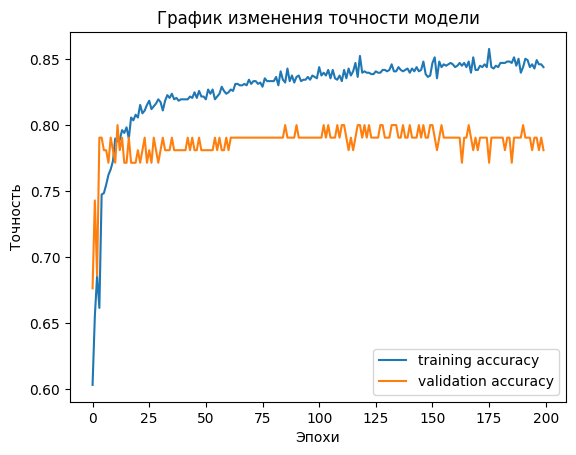

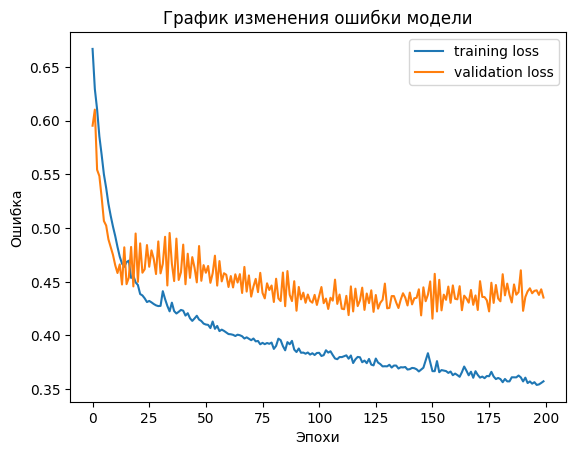

In [ ]:
plt.figure()
plt.plot(model.history.history["accuracy"], label="training accuracy")
plt.plot(model.history.history["val_accuracy"], label="validation accuracy")
plt.legend()
plt.title("График изменения точности модели")
plt.xlabel("Эпохи")
plt.ylabel("Точность")
plt.show()

plt.figure()
plt.plot(model.history.history["loss"], label="training loss")
plt.plot(model.history.history["val_loss"], label="validation loss")
plt.legend()
plt.title("График изменения ошибки модели")
plt.xlabel("Эпохи")
plt.ylabel("Ошибка")
plt.show()

In [ ]:
# Загрузка весов самой лучшей модели с самой маленькой ошибкой на валидации
model.load_weights('/content/best_model.weights.h5')

In [ ]:
# Тестирование модели на тестовых данных
mlp_loss, mlp_accuracy = model.evaluate(X_test, y_test)
print("Точность модели MLP: " + str(mlp_accuracy))

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7953 - loss: 0.5428 
Точность модели MLP: 0.7748091816902161


## **3. Обучение классических классификаторов машиннного обучения из библиотеки sklearn и сравнение с разработанным многослойным персептроном**

In [ ]:
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

# Обучение и тестирование алгоритма LogisticRegression
log_reg = LogisticRegression()
log_reg.fit(X_train, y_train)
log_reg_pred = log_reg.predict(X_test)
print("Classification Report for LogisticRegression")
print(classification_report(y_test, log_reg_pred))

# Обучение и тестирование алгоритма KNN с параметрами по-умолчанию.
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)
knn_pred = knn.predict(X_test)
print("Classification Report for KNeighborsClassifier")
print(classification_report(y_test, knn_pred))

# Обучение и тестирование алгоритма Random Forest с параметрами по-умолчанию.
random_forset = RandomForestClassifier()
random_forset.fit(X_train, y_train)
random_forset_pred = random_forset.predict(X_test)
print("Classification Report for RandomForestClassifier")
print(classification_report(y_test, random_forset_pred))

# Тестирование Multilayer Perceptron
mlp_pred = (model.predict(X_test).flatten() >= 0.5).astype(int) # осуществляем предсказание классов для тестовых данных и применяем решающее правило для выходных вероятностей
print("Classification Report for Our Multilayer Perceptron")
print(classification_report(y_test, mlp_pred.flatten()))

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Classification Report for LogisticRegression
              precision    recall  f1-score   support

           0       0.79      0.82      0.81       158
           1       0.71      0.67      0.69       104

    accuracy                           0.76       262
   macro avg       0.75      0.75      0.75       262
weighted avg       0.76      0.76      0.76       262

Classification Report for KNeighborsClassifier
              precision    recall  f1-score   support

           0       0.77      0.83      0.80       158
           1       0.70      0.62      0.66       104

    accuracy                           0.74       262
   macro avg       0.73      0.72      0.73       262
weighted avg       0.74      0.74      0.74       262

Classification Report for RandomForestClassifier
              precision    recall  f1-score   support

           0       0.81      0.85      0.83       158
           1       0.75      0.69      0.72       104

    accuracy                           0.

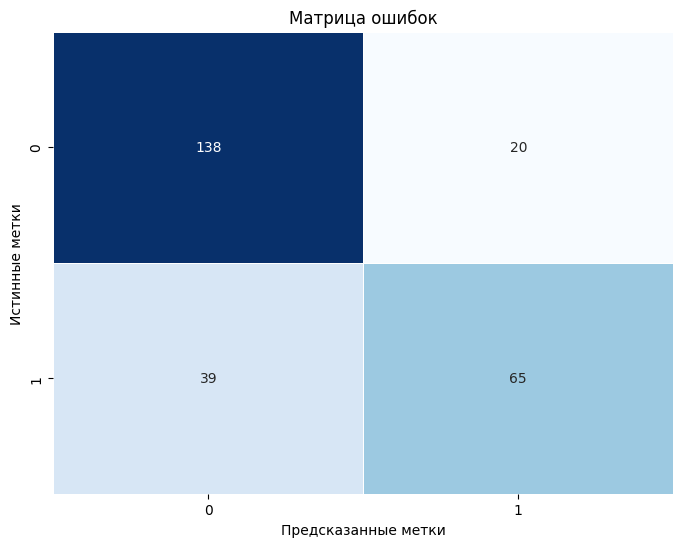

In [ ]:
from sklearn.metrics import confusion_matrix

# Построим матрицу ошибок для оценки качества классификационной модели
# Матрица ошибок имеет вид таблицы, где:
# Строки представляют фактические классы (истинные метки),
# Столбцы представляют предсказанные классы (то, что модель предсказала).
cm = confusion_matrix(y_test, mlp_pred)

cm_df = pd.DataFrame(cm,
                     index=np.unique(y_test),
                     columns=np.unique(y_test))

plt.figure(figsize=(8, 6))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues', cbar=False, linewidths=0.5)
plt.title('Матрица ошибок')
plt.xlabel('Предсказанные метки')
plt.ylabel('Истинные метки')
plt.show()

# **Пример задачи многоклассовой классификации**

Используемый набор данных является синтетическим и был создан в образовательных целях, что делает его идеальным для проектов по науке о данных и машинному обучению. Авторский исходный набор данных можно найти [здесь](https://www.kaggle.com/datasets/rabieelkharoua/predict-restaurant-menu-items-profitability).

**В этой задаче классификации цель — предсказать уровень рентабельности (Low, Medium, High) для каждого пункта меню на основе его категории, ингредиентов и цены с целью оптимизации состава меню, ценообразования и управления ресурсами для повышения прибыльности ресторанов.**

1. **ID ресторана**: Уникальный идентификатор ресторана.
2. **Категория меню**: Категория пункта меню, к которой относится блюдо (например, Закуски, Основные блюда, Десерты, Напитки).
3. **Пункт меню**: Название блюда или напитка, указанное в меню.
4. **Ингредиенты блюда**: Список ингредиентов, использованных в блюде (с конфиденциальной информацией для напитков).
5. **Цена**: Стоимость данного пункта меню в долларах, округленная до двух знаков после запятой.
6. **Рентабельность**: Целевая переменная, указывающая на уровень прибыльности конкретного пункта меню, который может быть "Высокий", "Средний" или "Низкий".

## **1. Подготовка набора данных для обучения многослойного персептрона**

In [ ]:
df = pd.read_csv('/content/restaurant_menu_optimization_data.csv', encoding='cp1251') # загрузка набора данных, используя библиотеку pandas
df # вывод набора данных

,ID ресторана,Категория меню,Пункт меню,Ингредиенты блюда,Цена,Рентабельность
0,R003,Beverages,Soda,['confidential'],2.55,Low
1,R001,Appetizers,Spinach Artichoke Dip,"['Tomatoes', 'Basil', 'Garlic', 'Olive Oil']",11.12,Medium
2,R003,Desserts,New York Cheesecake,"['Chocolate', 'Butter', 'Sugar', 'Eggs']",18.66,High
3,R003,Main Course,Chicken Alfredo,"['Chicken', 'Fettuccine', 'Alfredo Sauce', 'Pa...",29.55,High
4,R002,Main Course,Grilled Steak,"['Chicken', 'Fettuccine', 'Alfredo Sauce', 'Pa...",17.73,Medium
...,...,...,...,...,...,...
995,R003,Beverages,Soda,['confidential'],2.16,Low
996,R001,Appetizers,Caprese Salad,"['Tomatoes', 'Basil', 'Garlic', 'Olive Oil']",11.86,Medium
997,R003,Main Course,Vegetable Stir-Fry,"['Chicken', 'Fettuccine', 'Alfredo Sauce', 'Pa...",20.57,High
998,R002,Desserts,Tiramisu,"['Chocolate', 'Butter', 'Sugar', 'Eggs']",18.80,High


In [ ]:
# Применяем one-hot кодирование к категориальным признакам "ID ресторана", "Категория меню" и "Ингредиенты блюда" (т.к. признаки не имеют внутренних отношений, нет ранжирования, а также кол-во самих категорий небольшое)
df = pd.get_dummies(df, columns=['ID ресторана', 'Категория меню', 'Ингредиенты блюда'], dtype=int)

# Применяем Label Encoding к категориальным признакам "Пункт меню" и "Рентабельность"
label_encoder = LabelEncoder()
df['Пункт меню'] = label_encoder.fit_transform(df['Пункт меню'])
df['Рентабельность'] = label_encoder.fit_transform(df['Рентабельность'])

In [ ]:
df

,Пункт меню,Цена,Рентабельность,ID ресторана_R001,ID ресторана_R002,ID ресторана_R003,Категория меню_Appetizers,Категория меню_Beverages,Категория меню_Desserts,Категория меню_Main Course,"Ингредиенты блюда_['Chicken', 'Fettuccine', 'Alfredo Sauce', 'Parmesan']","Ингредиенты блюда_['Chocolate', 'Butter', 'Sugar', 'Eggs']","Ингредиенты блюда_['Tomatoes', 'Basil', 'Garlic', 'Olive Oil']",Ингредиенты блюда_['confidential']
0,11,2.55,1,0,0,1,0,1,0,0,0,0,0,1
1,12,11.12,2,1,0,0,1,0,0,0,0,0,1,0
2,9,18.66,0,0,0,1,0,0,1,0,0,1,0,0
3,2,29.55,0,0,0,1,0,0,0,1,1,0,0,0
4,6,17.73,2,0,1,0,0,0,0,1,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,11,2.16,1,0,0,1,0,1,0,0,0,0,0,1
996,1,11.86,2,1,0,0,1,0,0,0,0,0,1,0
997,15,20.57,0,0,0,1,0,0,0,1,1,0,0,0
998,14,18.80,0,0,1,0,0,0,1,0,0,1,0,0


In [ ]:
# Определяем целевую переменную y и признаки X
y = df['Рентабельность']
X = df.drop(columns=['Рентабельность'])

In [ ]:
# Используем нормализацию для приведения значений в диапазон от 0 до 1.
minmax_scaler = MinMaxScaler()
quantitative_cols = ['Цена'] # Определение списка количественных переменных
X[quantitative_cols] = minmax_scaler.fit_transform(X[quantitative_cols])

In [ ]:
# Переводим целевую переменную y и признаки X в numpy массивы
y = y.values
X = X.values

In [ ]:
print("Количество объектов: " + str(X.shape[0]))
print("Количество признаков: " + str(X.shape[1]))
input_shape = X.shape[1] # размер входа нейронной сети, определяется по кол-ву признаков

Количество объектов: 1000
Количество признаков: 13


In [ ]:
# Разделение данных на обучающий и тестовый наборы
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Преобразование меток классов в one-hot кодировку. В таком случае в качестве функции ошибки используется categorical_crossentropy, а в качестве метрики точность categorical_accuracy
# Если вы хотите использовать метки классов в label encoding (численном виде). В таком случае в качестве функции ошибки используется sparse_categorical_crossentropy, а в качестве метрики точность sparse_categorical_accuracy
y_train_cat = to_categorical(y_train)
y_test_cat = to_categorical(y_test)

## **2. Создание и обучение собственной модели многослойного персептрона**

In [ ]:
def createModel(input_shape):
  input_x = Input(shape=(input_shape, ))       # для создания модели необходимо предопределить вход и размерность входных данных input_shape
  fc1 = Dense(256, activation='relu')(input_x) # добавляем скрытый слой с 256 нейронами с функцией активации RELU
  fc2 = Dense(128, activation='relu')(fc1)     # добавляем второй скрытый слой с 128 нейронами с функцией активации RELU
  out = Dense(3, activation='softmax')(fc2)    # добавляем выходной слой с 3 нейронами (по кол-ву классов) и функцией активации софтмакс для многоклассовой классификации
  return Model(inputs=input_x, outputs=out)    # создаём модель, задавая вход и выход и возвращаем эту модель для последующих манипуляций

def trainModel(X_train, y_train):
  # Сохранение только наилучшей модели с наименьшей ошибкой на валидации
  save_callback = ModelCheckpoint(filepath='best_model.weights.h5', # путь и название файла лучшей модели.
                                  monitor = 'val_loss',             # отслеживать каждую эпоху показать val_loss
                                  save_best_only = True,            # сохранять только самую лучшую модель
                                  save_weights_only=True,           # сохранять только веса модели (не всю модель);
                                  mode = 'min',                     # режим оптимизации min (найти минимальную ошибку)
                                  verbose=1)                        # 1 означает выводить информацию о нахождении и сохранении лучшей модели в процессе обучения, 0 означает не выводить.

  model = createModel(input_shape) # создаётся модель принимающая на вход входные сигналы с размерностью input_shape

  # Компиляция модели
  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), # алгоритм градиентного спуска, минимизирующий функцию ошибки. В нём можно задать скорость обучения (по умолчанию 0.001)
                loss='categorical_crossentropy',                         # функция ошибки categorical_crossentropy категориальная кроссэнтропия для задачи многоклассовой классификации.
                metrics=['categorical_accuracy'])                        # метрика accuracy - точность.

  model.summary() # вывод информации о созданной модели

  model.fit(x=X_train,                  # признаки X
            y=y_train,                  # желаемый выход y
            epochs=400,                 # количество эпох обучения. эпоха представляет собой один полный проход через все данные обучающего набора.
            batch_size=128,             # параметр, с помощью которого можно регулировать порцию подаваемых примеров для сети за одну итерацию обучения (по-умолчанию он равен 32).
            validation_split=0.1,       # добавим валидационные данные (10% от обучающего набора) для проверки работоспособности сети на незнакомых данных каждую эпоху, чтобы отслеживать процесс возможного возникновения переобучения нейронной сети
            callbacks=[save_callback]   # используем в процессе обучения созданный ModelCheckpoint
            )
  return model # обученная модель возвращается для тестирования и других манипуляций

In [ ]:
# Запуск обучения нейронной сети
model = trainModel(X_train, y_train_cat)

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 13)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 256)                 │           3,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 3)                   │             387 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 36,867 (144.01 KB)

 Trainable params: 36,867 (144.01 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/400
1/6 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - categorical_accuracy: 0.1172 - loss: 1.6327
Epoch 1: val_loss improved from inf to 0.97921, saving model to best_model.weights.h5
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - categorical_accuracy: 0.2258 - loss: 1.3062 - val_categorical_accuracy: 0.5125 - val_loss: 0.9792
Epoch 2/400
1/6 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - categorical_accuracy: 0.5469 - loss: 1.0881
Epoch 2: val_loss improved from 0.97921 to 0.91333, saving model to best_model.weights.h5
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - categorical_accuracy: 0.5248 - loss: 1.0319 - val_categorical_accuracy: 0.6000 - val_loss: 0.9133
Epoch 3/400
1/6 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - categorical_accuracy: 0.5703 - loss: 0.9381
Epoch 3: val_loss improved from 0.91333 to 0.84889, saving model to best_model.weights.h5
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - categorical_accuracy: 0.5645 - loss: 0.9392 - val_categorical_accuracy: 0.6375 - val_loss: 0.8489
Epoch 4/400
1/6 ━━━━━━━━━━━━━━━━━━

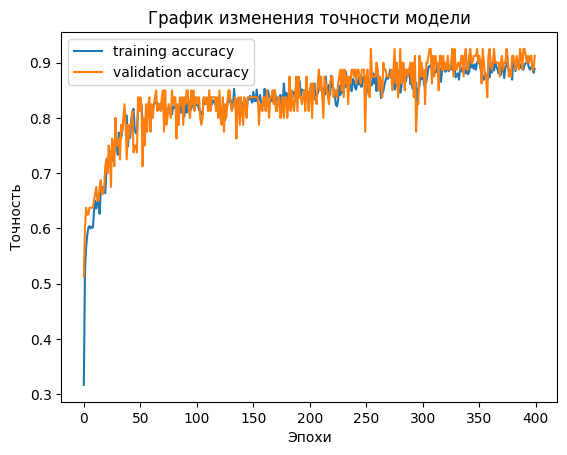

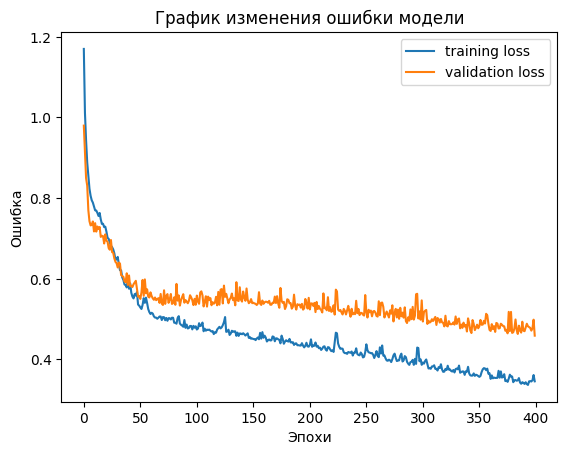

In [ ]:
plt.figure()
plt.plot(model.history.history["categorical_accuracy"], label="training accuracy")
plt.plot(model.history.history["val_categorical_accuracy"], label="validation accuracy")
plt.legend()
plt.title("График изменения точности модели")
plt.xlabel("Эпохи")
plt.ylabel("Точность")
plt.show()

plt.figure()
plt.plot(model.history.history["loss"], label="training loss")
plt.plot(model.history.history["val_loss"], label="validation loss")
plt.legend()
plt.title("График изменения ошибки модели")
plt.xlabel("Эпохи")
plt.ylabel("Ошибка")
plt.show()

In [ ]:
# Загрузка весов самой лучшей модели с самой маленькой ошибкой на валидации
model.load_weights('/content/best_model.weights.h5')

In [ ]:
# Тестирование модели на тестовых данных
mlp_loss, mlp_accuracy = model.evaluate(X_test, y_test_cat)
print("Точность модели MLP: " + str(mlp_accuracy))

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - categorical_accuracy: 0.8327 - loss: 0.6890 
Точность модели MLP: 0.8500000238418579


## **3. Обучение классических классификаторов машиннного обучения из библиотеки sklearn и сравнение с разработанным многослойным персептроном**

In [ ]:
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

# Обучение и тестирование алгоритма LogisticRegression
log_reg = LogisticRegression()
log_reg.fit(X_train, y_train)
log_reg_pred = log_reg.predict(X_test)
print("Classification Report for LogisticRegression")
print(classification_report(y_test, log_reg_pred))

# Обучение и тестирование алгоритма KNN с параметрами по-умолчанию.
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)
knn_pred = knn.predict(X_test)
print("Classification Report for KNeighborsClassifier")
print(classification_report(y_test, knn_pred))

# Обучение и тестирование алгоритма Random Forest с параметрами по-умолчанию.
random_forset = RandomForestClassifier()
random_forset.fit(X_train, y_train)
random_forset_pred = random_forset.predict(X_test)
print("Classification Report for RandomForestClassifier")
print(classification_report(y_test, random_forset_pred))

# Тестирование Multilayer Perceptron
mlp_pred = model.predict(X_test)
mlp_pred = np.argmax(mlp_pred, axis=1) # чтобы получить предсказанные классы, используйте функцию argmax, которая вернет индекс класса с наибольшей вероятностью.
print("Classification Report for Our Multilayer Perceptron")
print(classification_report(y_test, mlp_pred))

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no pre

Classification Report for LogisticRegression
              precision    recall  f1-score   support

           0       0.88      0.92      0.90        77
           1       0.00      0.00      0.00        25
           2       0.78      0.95      0.86        98

    accuracy                           0.82       200
   macro avg       0.55      0.62      0.59       200
weighted avg       0.72      0.82      0.77       200

Classification Report for KNeighborsClassifier
              precision    recall  f1-score   support

           0       0.86      0.90      0.88        77
           1       0.93      0.52      0.67        25
           2       0.87      0.94      0.90        98

    accuracy                           0.87       200
   macro avg       0.89      0.78      0.82       200
weighted avg       0.87      0.87      0.86       200

Classification Report for RandomForestClassifier
              precision    recall  f1-score   support

           0       0.90      0.95      0.9

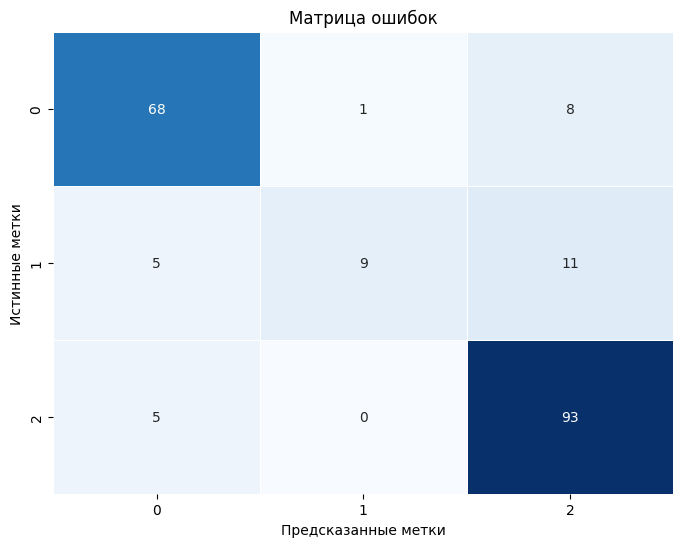

In [ ]:
from sklearn.metrics import confusion_matrix

# Построим матрицу ошибок для оценки качества классификационной модели
# Матрица ошибок имеет вид таблицы, где:
# Строки представляют фактические классы (истинные метки),
# Столбцы представляют предсказанные классы (то, что модель предсказала).
cm = confusion_matrix(y_test, mlp_pred)

cm_df = pd.DataFrame(cm,
                     index=np.unique(y_test),
                     columns=np.unique(y_test))

plt.figure(figsize=(8, 6))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues', cbar=False, linewidths=0.5)
plt.title('Матрица ошибок')
plt.xlabel('Предсказанные метки')
plt.ylabel('Истинные метки')
plt.show()